In [1]:
import tensorflow as tf
from tensorflow.keras.applications import densenet
from tensorflow.keras.applications.densenet import preprocess_input
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D
from tensorflow.keras.models import Model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import os
import cv2
import tensorflow as tf
import re
import pickle
from PIL import Image
from skimage.transform import resize
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import time
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Input, Embedding, Conv2D, Concatenate, Flatten, Add, Dropout, GRU
import random
import datetime
from nltk.translate.bleu_score import sentence_bleu

In [ ]:
train_data = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_Train_Data.csv')
test_data = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_Test_Data.csv')
cv_data = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_CV_Data.csv')

In [3]:
print('train data shape : ',train_data.shape)
train_data.head(2)

train data shape :  (2764, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR1082_IM-0058,NLMCXR_png/CXR1082_IM-0058-1001.png,NLMCXR_png/CXR1082_IM-0058-1001.png,startseq stable cardiomegaly . stable tortuos...
1,NLMCXR_png/CXR1883_IM-0572_0,NLMCXR_png/CXR1883_IM-0572-1001.png,NLMCXR_png/CXR1883_IM-0572-2001.png,startseq frontal and lateral views the chest s...


In [4]:
print('test data shape : ',test_data.shape)
test_data.head(2)

test data shape :  (389, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR2828_IM-1247_0,NLMCXR_png/CXR2828_IM-1247-1001.png,NLMCXR_png/CXR2828_IM-1247-2001.png,startseq heart size and mediastinal contour ar...
1,NLMCXR_png/CXR2777_IM-1217_0,NLMCXR_png/CXR2777_IM-1217-1001.png,NLMCXR_png/CXR2777_IM-1217-2001.png,startseq and lateral views the chest were obta...


In [5]:
print('CV data shape : ',cv_data.shape)
cv_data.head(2)

CV data shape :  (554, 4)


,Person_id,Image1,Image2,Report
0,NLMCXR_png/CXR3072_IM-1433_0,NLMCXR_png/CXR3072_IM-1433-1001.png,NLMCXR_png/CXR3072_IM-1433-2001.png,startseq leftsided medication injection has it...
1,NLMCXR_png/CXR1864_IM-0558_0,NLMCXR_png/CXR1864_IM-0558-1001.png,NLMCXR_png/CXR1864_IM-0558-3001.png,startseq heart size borderline enlarged . no ...


In [6]:
chexNet = densenet.DenseNet121(include_top=False, weights = None,   input_shape=(224,224,3), pooling="avg")
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
model = Model(inputs=chexNet.input, outputs=X)

In [ ]:
#loading pretrained weights for ChexNet model
model.load_weights('C:/Users/smart/Downloads/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [11]:
chexNet = Model(inputs = model.input, outputs = model.layers[-2].output)

In [12]:
chexNet.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [14]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


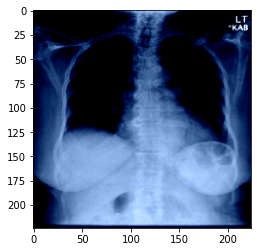

In [ ]:
img = load_image('C:/Users/smart/Downloads/NLMCXR_png/CXR1082_IM-0058-1001.png')
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


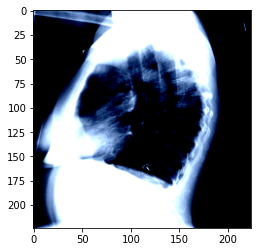

In [ ]:
img = load_image('C:/Users/smart/Downloads/NLMCXR_png/CXR2828_IM-1247-2001.png')
plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


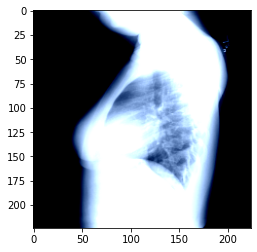

In [ ]:
img = load_image('C:/Users/smart/Downloads/NLMCXR_png/CXR1_1_IM-0001-3001.png')
plt.imshow(img[0])

In [18]:
Xnet_features = {}
for key, img1, img2, finding in tqdm(train_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(test_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

for key, img1, img2, finding in tqdm(cv_data.values):
    i1 = load_image(img1)
    img1_features = chexNet.predict(i1)    
    i2 = load_image(img2)
    img2_features = chexNet.predict(i2)
    input_ = np.concatenate((img1_features, img2_features), axis=1)
    Xnet_features[key] = input_

100%|██████████| 554/554 [01:47<00:00,  5.17it/s]


In [ ]:
Xnet_features['C:/Users/smart/Downloads/NLMCXR_png/CXR236_IM-0924_0'].shape

(1, 2048)

In [ ]:
# save the file for future use
f = open('Image_features_encoder_decoder.pickle','wb')
pickle.dump(Xnet_features, f)
f.close()

In [40]:
len(Xnet_features)

3707

Encoder Decoder Model

In [41]:
X_train = train_data['Person_id']
X_test = test_data['Person_id']
X_cv = cv_data['Person_id']
y_train = train_data['Report']
y_test =  test_data['Report']
y_cv =  cv_data['Report']

In [42]:
cheXnet_Features = Xnet_features

In [43]:
tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

In [44]:
pading_size = 153   # Max length

In [45]:
vocab_size = len(tokenizer.word_index.keys()) + 1

In [ ]:
import numpy as np

glove_vectors = {}

# Open the GloVe file in read mode ('r')
with open('C:/Users/smart/Downloads/archive (1)/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # Split each line by spaces
        values = line.split()
        # The first value is the word
        word = values[0]
        # The remaining values are the vector components (convert to NumPy array)
        vector = np.asarray(values[1:], "float32")
        # Add the word and vector to the dictionary
        glove_vectors[word] = vector

In [47]:
embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [ ]:
# # Save tokenizer
# with open('tokenizer.pkl', 'wb') as f:
#     pickle.dump(tokenizer, f)

# # Save embedding matrix
# with open('embedding_matrix.pkl', 'wb') as f:
#     pickle.dump(embedding_matrix, f)

In [48]:
BATCH_SIZE = 12

In [49]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = cheXnet_Features[id_.decode('utf-8')][0]
    return img_feature, report

In [50]:
def dataset_generator(img_name, caption):
  
    dataset = tf.data.Dataset.from_tensor_slices((img_name, caption))

  # Use map to load the numpy files in parallel
    dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.string]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
    dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [51]:
train_generator = dataset_generator(X_train, y_train)
cv_generator = dataset_generator(X_cv, y_cv)

In [52]:
def bytes_to_string(arr):
    '''The generator gives provides data in bytes. This function converts them back to strings for manipulation'''
    for i in range(len(arr)):
        arr[i] = arr[i].decode('utf-8')
    return arr

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

def convert(images, reports):
    '''This function takes the batch of data and converts them into a new dataset'''
    imgs = []
    in_reports = []
    out_reports = []
    for i in range(len(images)):
        sequence = [tokenizer.word_index[e] for e in reports[i].split() if e in tokenizer.word_index.keys()]
        for j in range(1, len(sequence)):
            in_seq = sequence[:j]
            out_seq = sequence[j]
            out_seq = tf.keras.utils.to_categorical(out_seq, num_classes=vocab_size)

            imgs.append(images[i])

            # Pad the input sequence
            in_seq = pad_sequences([in_seq], maxlen=153, padding='post')[0]

            in_reports.append(in_seq)
            out_reports.append(out_seq)

    return np.array(imgs), np.array(in_reports), np.array(out_reports)

In [ ]:
input1 = Input(shape=(2048,), name='Image_input')
dense1 = Dense(256, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')(input1)

input2 = Input(shape=(153,), name='Text_Input')
embedding_layer = Embedding(input_dim = vocab_size, output_dim = 300, input_length=153, mask_zero=True, trainable=False, 
                weights=[embedding_matrix], name="Embedding_layer")
emb = embedding_layer(input2)

LSTM1 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), return_sequences=True, name="LSTM1")(emb)
#LSTM1_output = LSTM1(emb)

LSTM2 = LSTM(units=256, activation='tanh', recurrent_activation='sigmoid', use_bias=True, 
            kernel_initializer=tf.keras.initializers.glorot_uniform(seed=23),
            recurrent_initializer=tf.keras.initializers.orthogonal(seed=7),
            bias_initializer=tf.keras.initializers.zeros(), name="LSTM2")
LSTM2_output = LSTM2(LSTM1)

dropout1 = Dropout(0.5, name='dropout1')(LSTM2_output)

dec =  tf.keras.layers.Add()([dense1, dropout1])

fc1 = Dense(256, activation='relu', kernel_initializer=tf.keras.initializers.he_normal(seed = 63), name='fc1')
fc1_output = fc1(dec)
dropout2 = Dropout(0.4, name='dropout2')(fc1_output)
output_layer = Dense(vocab_size, activation='softmax', name='Output_layer')
output = output_layer(dropout2)

encoder_decoder = Model(inputs = [input1, input2], outputs = output)
encoder_decoder.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None, 153)]        0                                            
__________________________________________________________________________________________________
Embedding_layer (Embedding)     (None, 153, 300)     431100      Text_Input[0][0]                 
__________________________________________________________________________________________________
LSTM1 (LSTM)                    (None, 153, 256)     570368      Embedding_layer[0][0]            
__________________________________________________________________________________________________
Image_input (InputLayer)        [(None, 2048)]       0                                            
____________________________________________________________________________________________

In [ ]:
loss_function = tf.keras.losses.CategoricalCrossentropy(from_logits=False, reduction='sum_over_batch_size')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [57]:
optimizer = tf.keras.optimizers.Adam(0.001)
encoder_decoder.compile(optimizer, loss = maskedLoss)

current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/train'
val_log_dir = 'Tensorboard/logs_m1/fit3/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
#training for 20 epochs
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(20):
    print('EPOCH : ',epoch+1)
    start = time.time()
    batch_loss_tr = 0
    batch_loss_vl = 0
    
    for img, report in train_generator:
       
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.train_on_batch([img_input, rep_input], output_word)
        
        batch_loss_tr += results

    train_loss = batch_loss_tr/(X_train.shape[0]//14)
 #   print('Saving Tensorboard')
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
    
    for img, report in cv_generator:
        
        r1 = bytes_to_string(report.numpy())
        img_input, rep_input, output_word = convert(img.numpy(), r1)
        rep_input = pad_sequences(rep_input, maxlen=153, padding='post')
        results = encoder_decoder.test_on_batch([img_input, rep_input], output_word)
        batch_loss_vl += results
    
    val_loss = batch_loss_vl/(X_cv.shape[0]//14)
    
    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)

    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Val Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    encoder_decoder.save_weights('encoder_decoder_epoch_'+ str(epoch+1) + '.weights.h5')
    print('--------------------------------------------------------------------------------------------')

EPOCH :  1
Training Loss: 0.003811859837756847,  Val Loss: 0.003378847691540917
Time Taken for this Epoch : 35.43555426597595 sec
--------------------------------------------------------------------------------------------
EPOCH :  2
Training Loss: 0.0031122732233861226,  Val Loss: 0.002617753128736065
Time Taken for this Epoch : 19.199682235717773 sec
--------------------------------------------------------------------------------------------
EPOCH :  3
Training Loss: 0.00251724414390318,  Val Loss: 0.002215469253058426
Time Taken for this Epoch : 19.386552333831787 sec
--------------------------------------------------------------------------------------------
EPOCH :  4
Training Loss: 0.0021881484385192166,  Val Loss: 0.0019762548498618296
Time Taken for this Epoch : 19.365970134735107 sec
--------------------------------------------------------------------------------------------
EPOCH :  5
Training Loss: 0.0020142961671661,  Val Loss: 0.0018996467652659004
Time Taken for this Epoc

Text(0.5, 1.0, 'Loss per epoch')

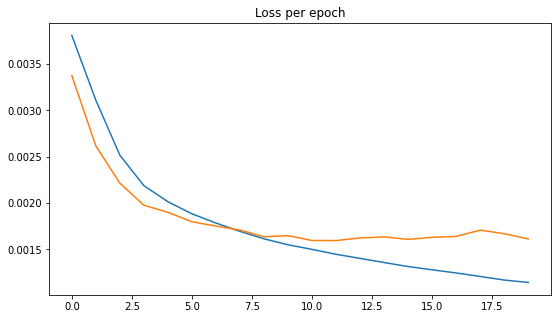

In [59]:
plt.figure(figsize=(9,5))

plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)

plt.title('Loss per epoch')

In [ ]:
encoder_decoder.load_weights("C:/Users/smart/Downloads/Automated Report Generation/encoder_decoder_epoch_5.h5")

In [84]:
# encoder
encoder_input = encoder_decoder.input[0]
encoder_output = encoder_decoder.get_layer('dense_encoder').output
encoder_model = Model(encoder_input, encoder_output)

# decoder# 
text_input = encoder_decoder.input[1]
enc_output = Input(shape=(256,), name='Enc_Output')
text_output = encoder_decoder.get_layer('LSTM2').output
add1 = tf.keras.layers.Add()([text_output, enc_output])
fc_1 = fc1(add1)
decoder_output = output_layer(fc_1)

decoder_model = Model(inputs = [text_input, enc_output], outputs = decoder_output)

In [85]:
def greedysearch(img):
    image = cheXnet_Features[img]
    input_ = 'startseq'
    image_features = encoder_model.predict(image)
    
    result = []
    for i in range(153):
        input_tok = [tokenizer.word_index[w] for w in input_.split()]
        input_padded = pad_sequences([input_tok], 153, padding='post')
        predictions = decoder_model.predict([input_padded, image_features])
        arg = np.argmax(predictions)
        if arg != 7:   # endseq
            result.append(tokenizer.index_word[arg])
            input_ = input_ + ' ' + tokenizer.index_word[arg]
        else:
            break
    rep = ' '.join(e for e in result)
    return rep

In [86]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

In [87]:
def get_result(idx=0):
  
  plt.figure(figsize=(9,5))

  pre_Report = greedysearch(cv_data['Person_id'][idx]) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_data['Report'][idx])

  plt.subplot(121)
  img = load_image(cv_data['Image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_data['Image2'][idx])
  plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq no pneumothora .  no large pleural effusions .  heart size normal .  no acute focal space opacities .  endseq


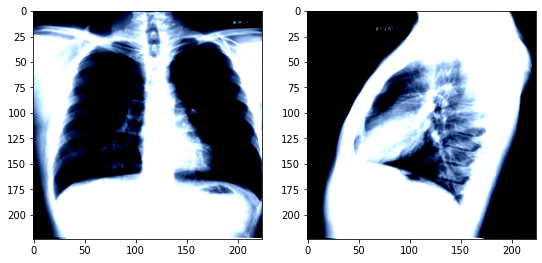

In [88]:
get_result(2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinal contour within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart mildly enlarged .  pulmonary vascularity increased .  there again mild elevation the right hemidiaphragm .  air space disease andor atelectasis noted right lung base .  there also streaky opacity the left base .  the costophrenic are blunted .  endseq


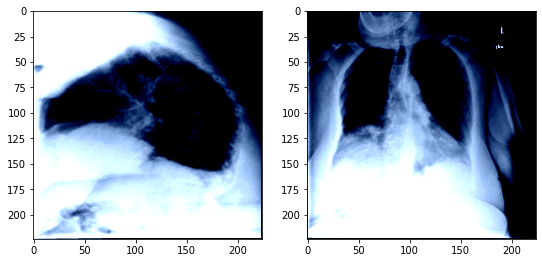

In [89]:
get_result(98)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . no focal consolidation pleural pleural effusion .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  there again biapical scarring .  small stable calcified left lower lobe granuloma .  the lungs are otherwise clear .  endseq


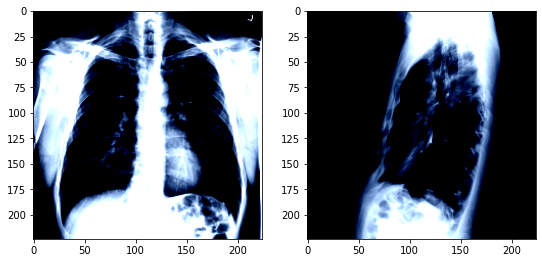

In [90]:
get_result(48)

In [91]:
def rem_fullstops(text):
    '''Removes punctuations'''
    punctuations = '''.''' # full stop is not removed
    new_text = []
    for char in text:
        if char in punctuations: 
            text = text.replace(char, "")
    new_text.append(' '.join(e for e in text.split()))
    return new_text[0]

In [ ]:
from tqdm.notebook import tqdm

bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

In [ ]:
a = sum(bleu1)/X_cv.shape[0]
b = sum(bleu2)/X_cv.shape[0]
c = sum(bleu3)/X_cv.shape[0]
d = sum(bleu4)/X_cv.shape[0]

print('Bleu1 Score: ',a)
print('Bleu2 Score: ',b)
print('Bleu3 Score: ',c)
print('Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Blue score:",(a+b+c+d)/4)

Bleu1 Score:  0.1813011714955598
Bleu2 Score:  0.17041689497849832
Bleu3 Score:  0.17754108502201618
Bleu4 Score:  0.19533480354978888
-----------------------------------------------------------------------
Avg Blue score: 0.18114848876146578


In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = greedysearch(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

In [ ]:
a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('Bleu1 Score: ',a)
print('Bleu2 Score: ',b)
print('Bleu3 Score: ',c)
print('Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Blue score:",(a+b+c+d)/4)

Bleu1 Score:  0.16357241534275888
Bleu2 Score:  0.15045014851595584
Bleu3 Score:  0.15754604224530216
Bleu4 Score:  0.17542506415900994
-----------------------------------------------------------------------
Avg Blue score: 0.1617484175657567


In [92]:
# beam_width = 2
def beamsearch(image, beam_width = 2):
    
    start = [tokenizer.word_index['startseq']]

    sequences = [[start, 0]]
    
    img_features = cheXnet_Features[image]
    img_features = encoder_model.predict(img_features)
    finished_seq = []
    
    for i in range(153):
        all_candidates = []
        new_seq = []
        for s in sequences:

            text_input = pad_sequences([s[0]], 153, padding='post')
            predictions = decoder_model.predict([text_input,img_features])
            top_words = np.argsort(predictions[0])[-beam_width:] 
            seq, score = s
            
            for t in top_words:
                candidates = [seq + [t], score - np.log(predictions[0][t])]
                all_candidates.append(candidates)
                
        sequences = sorted(all_candidates, key = lambda l: l[1])[:beam_width]
        # checks for 'endseq' in each seq in the beam
        count = 0
        for seq,score in sequences:
            if seq[len(seq)-1] == tokenizer.word_index['endseq']:
                score = score/len(seq)   # normalized
                finished_seq.append([seq, score])
                count+=1
            else:
                new_seq.append([seq, score])
        beam_width -= count
        sequences = new_seq
        
        # if all the sequences reaches its end before 155 timesteps
        if not sequences:
            break
        else:
            continue
        
    sequences = finished_seq[-1] 
    rep = sequences[0]
    score = sequences[1]
    temp = []
    rep.pop(0)
    for word in rep:
        if word != tokenizer.word_index['endseq']:
            temp.append(tokenizer.index_word[word])
        else:
            break    
    rep = ' '.join(e for e in temp)        
    
    return rep, score

In [93]:
def get_result(beam_width,idx=0):
  
  plt.figure(figsize=(9,5))

  pre_Report,Score = beamsearch(cv_data['Person_id'][idx],beam_width) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('Score is :',Score)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_data['Report'][idx])

  plt.subplot(121)
  img = load_image(cv_data['Image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_data['Image2'][idx])
  plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinal unremarkable . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.715110859911268
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  low lung volumes with no significant airspace consolidation .  no pleural effusion pneumothora .  visualized osseous structures are unremarkable appearance .  endseq


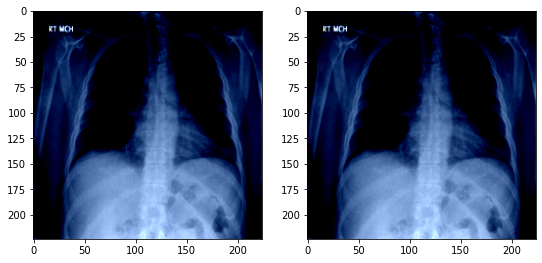

In [94]:
# beam_width = 2
get_result(2,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size normal . the mediastinum contours are within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.5355977995028037
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  the lungs are clear .  endseq


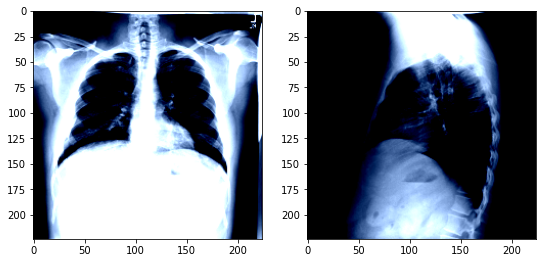

In [95]:
# beam_width = 2
get_result(2,7)

In [ ]:
from tqdm.notebook import tqdm
# beam_width = 2
'''CV'''

bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,2)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('CV Bleu1 Score: ',a)
print('CV Bleu2 Score: ',b)
print('CV Bleu3 Score: ',c)
print('CV Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg CV Blue score:",(a+b+c+d)/4)

print('=====================================================================================')

# beam_width = 2
'''TEST'''
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,2)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('Test Bleu1 Score: ',a)
print('Test Bleu2 Score: ',b)
print('Test Bleu3 Score: ',c)
print('Test Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Test Blue score:",(a+b+c+d)/4)


CV Bleu1 Score:  0.4431255936227122
CV Bleu2 Score:  0.3098561134547433
CV Bleu3 Score:  0.31468296277522284
CV Bleu4 Score:  0.35990415454093605
-----------------------------------------------------------------------
Avg CV Blue score: 0.3568922060984036



Test Bleu1 Score:  0.2912680411096469
Test Bleu2 Score:  0.207034308388247
Test Bleu3 Score:  0.21311129742783588
Test Bleu4 Score:  0.24675493283561065
-----------------------------------------------------------------------
Avg Test Blue score: 0.2395421449403351


In [ ]:
from tqdm.notebook import tqdm
# beam_width = 5
'''CV'''

bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,5)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('CV Bleu1 Score: ',a)
print('CV Bleu2 Score: ',b)
print('CV Bleu3 Score: ',c)
print('CV Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg CV Blue score:",(a+b+c+d)/4)

print('=====================================================================================')

# beam_width = 5
'''TEST'''
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,5)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('Test Bleu1 Score: ',a)
print('Test Bleu2 Score: ',b)
print('Test Bleu3 Score: ',c)
print('Test Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Test Blue score:",(a+b+c+d)/4)


CV Bleu1 Score:  0.49315195463081307
CV Bleu2 Score:  0.3364148008701202
CV Bleu3 Score:  0.32786218875600814
CV Bleu4 Score:  0.3742228380850862
-----------------------------------------------------------------------
Avg CV Blue score: 0.3829129455855069



Test Bleu1 Score:  0.3314679715747508
Test Bleu2 Score:  0.2287347207212481
Test Bleu3 Score:  0.22166958182138657
Test Bleu4 Score:  0.2585134869156888
-----------------------------------------------------------------------
Avg Test Blue score: 0.26009644025826856


In [ ]:
from tqdm.notebook import tqdm
# beam_width = 7
'''CV'''

bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,7)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('CV Bleu1 Score: ',a)
print('CV Bleu2 Score: ',b)
print('CV Bleu3 Score: ',c)
print('CV Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg CV Blue score:",(a+b+c+d)/4)

print('=====================================================================================')

# beam_width = 7
'''TEST'''
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []

for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep,score = beamsearch(img,7)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_test.shape[0]
b = sum(bleu2)/X_test.shape[0]
c = sum(bleu3)/X_test.shape[0]
d = sum(bleu4)/X_test.shape[0]

print('Test Bleu1 Score: ',a)
print('Test Bleu2 Score: ',b)
print('Test Bleu3 Score: ',c)
print('Test Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Test Blue score:",(a+b+c+d)/4)


CV Bleu1 Score:  0.5045278287455154
CV Bleu2 Score:  0.3486129728173558
CV Bleu3 Score:  0.3340529472544908
CV Bleu4 Score:  0.37893574981149486
-----------------------------------------------------------------------
Avg CV Blue score: 0.39153237465721424



Test Bleu1 Score:  0.3406031120390907
Test Bleu2 Score:  0.2344795461556287
Test Bleu3 Score:  0.2263127304699709
Test Bleu4 Score:  0.26361966375328694
-----------------------------------------------------------------------
Avg Test Blue score: 0.26625376310449433


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity are within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen . no acute bony abnormality .
Score is : 0.4401072240580106
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  low lung volumes with no significant airspace consolidation .  no pleural effusion pneumothora .  visualized osseous structures are unremarkable appearance .  endseq


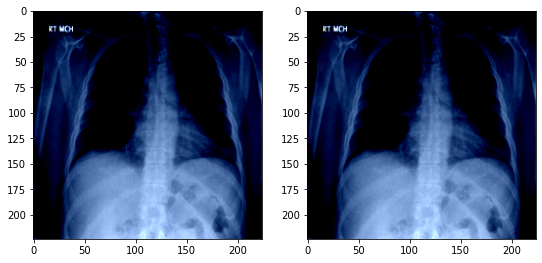

In [ ]:
get_result(5,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and mediastinal contours are within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.5155239434870265
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  the lungs are clear .  endseq


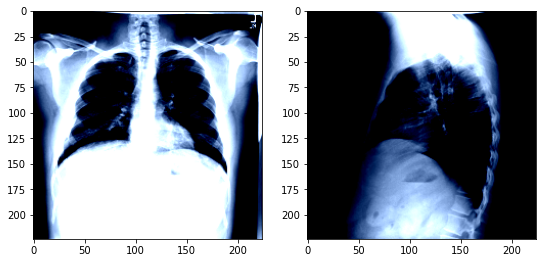

In [96]:
get_result(5,7)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are free focal airspace disease . no pleural effusion pneumothora .
Score is : 0.5601838477887213
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the cardiac silhouette upper mediastinum and pulmonary vasculature are within normal limits .  there no acute air space infiltrate pleural effusion pneumothora .  endseq


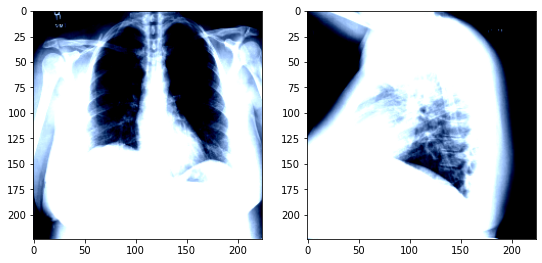

In [97]:
get_result(5,21)

In [ ]:
train_dataset = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_Train_Data.csv')
cv_dataset = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_CV_Data.csv')
test_dataset = pd.read_csv('C:/Users/smart/Downloads/Automated Report Generation/Final_Test_Data.csv')

In [ ]:
chexNet = chex = densenet.DenseNet121(include_top=False, weights = None, input_shape=(224,224,3))
X = chexNet.output
X = Dense(14, activation="sigmoid", name="predictions")(X)
chexNet = Model(inputs=chexNet.input, outputs=X)

In [ ]:
chexNet.load_weights('C:/Users/smart/Downloads/brucechou1983_CheXNet_Keras_0.3.0_weights.h5')

In [ ]:
model = Model(inputs = chexNet.input, outputs = chexNet.layers[-2].output)

In [ ]:
model.summary()

Model: "model_18"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


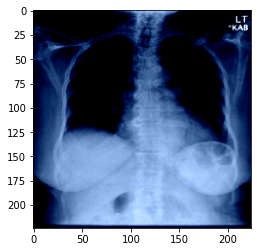

In [ ]:
img = load_image('C:/Users/smart/Downloads/NLMCXR_png/CXR1082_IM-0058-1001.png')
plt.imshow(img[0])

In [ ]:
from tqdm import tqdm_notebook as tqdm

def image_features(train, test, cv):
    Xnet_features_attention = {}
    
    for key, img1, img2, finding in tqdm(train.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
    
    for key, img1, img2, finding in tqdm(test.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_

    for key, img1, img2, finding in tqdm(cv.values):
        i1 = load_image(img1)
        img1_features = model.predict(i1)

        i2 = load_image(img2)
        img2_features = model.predict(i2)

        input_ = np.concatenate((img1_features, img2_features), axis=2)
        input_ = tf.reshape(input_, (input_.shape[0], -1, input_.shape[-1]))

        Xnet_features_attention[key] = input_
        
    return Xnet_features_attention

In [ ]:
Xnet_features_attention = image_features(train_dataset, test_dataset, cv_dataset)

In [ ]:
546 % 14 

0

In [ ]:
Xnet_features_attention['C:/Users/smart/Downloads/NLMCXR_png/CXR1796_IM-0517_0'].shape

TensorShape([1, 98, 1024])

In [ ]:
# save the file for future use
f = open('Image_features_for_attention_model.pickle','wb')
pickle.dump(Xnet_features_attention, f)
f.close()

In [ ]:
X_train = train_dataset['Person_id'][:2758]
X_test = test_dataset['Person_id'][:378]
X_cv = cv_dataset['Person_id'][:546]
y_train = train_dataset['Report'][:2758]
y_test = test_dataset['Report'][:378]
y_cv = cv_dataset['Report'][:546]

In [ ]:
max_capt_len = 153
pad_size = max_capt_len

tokenizer = Tokenizer(filters='!"#$%&()*+,-/:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(y_train.values)

train_rep_tok = tokenizer.texts_to_sequences(y_train)
cv_rep_tok = tokenizer.texts_to_sequences(y_cv)
test_rep_tok = tokenizer.texts_to_sequences(y_test)

train_rep_padded = pad_sequences(train_rep_tok, maxlen=153, padding='post')
cv_rep_padded = pad_sequences(cv_rep_tok, maxlen=153, padding='post')
test_rep_padded = pad_sequences(test_rep_tok, maxlen=153, padding='post')

tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'

In [ ]:
BATCH_SIZE = 14
BUFFER_SIZE = 500

In [ ]:
a = Xnet_features_attention['C:/Users/smart/Downloads/NLMCXR_png/CXR1796_IM-0517_0'][0]
a.shape

TensorShape([98, 1024])

In [ ]:
def load_image(id_, report):
    '''Loads the Image Features with their corresponding Ids'''
    img_feature = Xnet_features_attention[id_.decode('utf-8')][0]
    return img_feature, report

In [ ]:
def dataset_generator(img_name_train,reps):
  
  dataset = tf.data.Dataset.from_tensor_slices((img_name_train, reps))
  # Use map to load the numpy files in parallel
  dataset = dataset.map(lambda item1, item2: tf.numpy_function(load_image, [item1, item2], [tf.float32, tf.int32]),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)

  # Shuffle and batch
  dataset = dataset.shuffle(500).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
  return dataset

In [ ]:
cv_rep_padded.shape

(546, 153)

In [ ]:
train_generator = dataset_generator(X_train.values, train_rep_padded)
cv_generator = dataset_generator(X_cv.values, cv_rep_padded)

In [ ]:
glove_vectors = {}

# Open the GloVe file in read mode ('r')
with open('C:/Users/smart/Downloads/archive (1)/glove.6B.300d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        # Split each line by spaces
        values = line.split()
        # The first value is the word
        word = values[0]
        # The remaining values are the vector components (convert to NumPy array)
        vector = np.asarray(values[1:], "float32")
        # Add the word and vector to the dictionary
        glove_vectors[word] = vector

In [ ]:
vocab_size = len(tokenizer.word_index.keys()) + 1

embedding_matrix = np.zeros((vocab_size,300))
for word, i in tokenizer.word_index.items():
    if word in glove_vectors.keys():
        vec = glove_vectors[word]
        embedding_matrix[i] = vec
    else:
        continue

In [ ]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, units):
        super(Encoder, self).__init__()
        self.units = units
        
    def build(self, input_shape):
        self.maxpool = tf.keras.layers.MaxPool1D()
        self.dense = Dense(self.units, kernel_initializer=tf.keras.initializers.glorot_uniform(seed = 56), name='dense_encoder')
        
    def call(self, input_, training=True):
        
        x = self.maxpool(input_)
        x = self.dense(x)
        
        return x
    
    def get_states(self, bs):
        
        return tf.zeros((bs, self.units))

In [ ]:
class Decoder(tf.keras.layers.Layer):
    
    def __init__(self, vocab_size, input_length, dec_units, att_units):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size
        self.input_length = input_length
        self.dec_units = dec_units
        self.att_units = att_units
        self.onestep_decoder = OneStepDecoder(self.vocab_size, self.att_units, self.dec_units)
    @tf.function    
    def call(self, dec_input, hidden_state, enc_output):
        all_outputs = tf.TensorArray(tf.float32, dec_input.shape[1], name='output_arrays')
        
        for timestep in range(dec_input.shape[1]):
            
            output, hidden_state, attention_weights = self.onestep_decoder(dec_input[:, timestep:timestep+1], 
                                                                           hidden_state, enc_output)
            
            all_outputs = all_outputs.write(timestep, output)
            
        all_outputs = tf.transpose(all_outputs.stack(), [1,0,2])
        return all_outputs
        
        return tf.zeros((bs, self.units))

In [ ]:
class OneStepDecoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, att_units, dec_units):
        super(OneStepDecoder, self).__init__()
        self.vocab_size = vocab_size
        self.att_units = att_units
        self.dec_units = dec_units
        
    def build(self, input_shape):
        self.embedding = Embedding(self.vocab_size, output_dim=300, input_length=max_capt_len, mask_zero=True,
                                   weights = [embedding_matrix],
                                   name="embedding_layer_decoder")
        self.gru = GRU(self.dec_units, return_sequences=True, return_state=True, name="Decoder_GRU")
        self.fc = Dense(self.vocab_size)
        
        self.V = Dense(1)
        self.W = Dense(self.att_units)
        self.U = Dense(self.att_units)
        
    def call(self, dec_input, hidden_state, enc_output):
       
        hidden_with_time = tf.expand_dims(hidden_state, 1)
        attention_weights = self.V(tf.nn.tanh(self.U(enc_output) + self.W(hidden_with_time)))        
        attention_weights = tf.nn.softmax(attention_weights, 1)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
       
        x = self.embedding(dec_input)
        x = tf.concat([tf.expand_dims(context_vector, axis=1),x], axis=-1)
        output, h_state = self.gru(x, initial_state = hidden_state)
        output = tf.reshape(output, (-1, output.shape[2]))
        x = self.fc(output)
        
        return x, h_state, attention_weights

In [ ]:
class Attention_Model(tf.keras.Model):
    def __init__(self, vocab, units, max_capt_len, att_units, batch_size):
        super(Attention_Model, self).__init__()
        self.batch_size = batch_size
        self.encoder = Encoder(units)
        self.decoder = Decoder(vocab_size, max_capt_len, units, att_units)
        
    def call(self, data):
        enc_input, dec_input = data[0], data[1]
    
        enc_output = self.encoder(enc_input)
        enc_state = self.encoder.get_states(self.batch_size)
        dec_output = self.decoder(dec_input, enc_state, enc_output)

        return dec_output

In [ ]:
units = 256
att_units = 10

In [ ]:
model_atten = Attention_Model(vocab_size, units, max_capt_len, att_units, BATCH_SIZE)

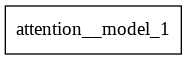

In [ ]:
tf.keras.utils.plot_model(model_atten,show_shapes=True,expand_nested=True)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='sum_over_batch_size')

def maskedLoss(y_true, y_pred):
    #getting mask value
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))
    
    #calculating the loss
    loss_ = loss_function(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #getting mean over all the values
    loss_ = tf.reduce_mean(loss_)
    return loss_

In [ ]:
model_atten.compile(optimizer=optimizer, loss=maskedLoss)

In [ ]:
EPOCHS = 10

In [ ]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
train_log_dir = 'Tensorboard/attention_OneStep/fit2/' + current_time + '/train'
val_log_dir = 'Tensorboard/attention_OneStep/fit2/' + current_time + '/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
val_summary_writer = tf.summary.create_file_writer(val_log_dir)

In [ ]:
for img, rep in cv_generator:
  print(img.shape,rep.shape)

(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)
(14, 98, 1024) (14, 153)


In [ ]:
epoch_train_loss = []
epoch_val_loss = []

for epoch in range(15):
    start = time.time()
    print("EPOCH: ", epoch+1)
    batch_loss_tr = 0
    batch_loss_val = 0

    for img, rep in train_generator:
        res = model_atten.train_on_batch([img, rep[:,:-1]], rep[:,1:])
        batch_loss_tr += res
        
    train_loss = batch_loss_tr/(X_train.shape[0]/BATCH_SIZE)

    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss, step = epoch)
 
    for img, rep in cv_generator:
        res = model_atten.test_on_batch([img, rep[:,:-1]], rep[:,1:])
        batch_loss_val += res
        
    val_loss = batch_loss_val/(X_cv.shape[0]/BATCH_SIZE)

    with val_summary_writer.as_default():
        tf.summary.scalar('loss', val_loss, step = epoch)    
        
    epoch_train_loss.append(train_loss)

    epoch_val_loss.append(val_loss)
    
    print('Training Loss: {},  Validation Loss: {}'.format(train_loss, val_loss))
    print('Time Taken for this Epoch : {} sec'.format(time.time()-start))   
    model_atten.save_weights('epoch_'+ str(epoch+1) + '.h5')
    print('---------------------------------------------------------------------------------')

EPOCH:  1
Training Loss: 0.2619428846058507,  Validation Loss: 0.18833483965733114
Time Taken for this Epoch : 209.3699083328247 sec
---------------------------------------------------------------------------------
EPOCH:  2
Training Loss: 0.1905702367651886,  Validation Loss: 0.157130245023813
Time Taken for this Epoch : 59.84448742866516 sec
---------------------------------------------------------------------------------
EPOCH:  3
Training Loss: 0.16380256350119102,  Validation Loss: 0.13806124986746374
Time Taken for this Epoch : 59.694589376449585 sec
---------------------------------------------------------------------------------
EPOCH:  4
Training Loss: 0.14696644736349884,  Validation Loss: 0.126835676913078
Time Taken for this Epoch : 59.67362976074219 sec
---------------------------------------------------------------------------------
EPOCH:  5
Training Loss: 0.13457499096538814,  Validation Loss: 0.11841330218773621
Time Taken for this Epoch : 59.96831274032593 sec
-------

Text(0.5, 1.0, 'Loss per epoch')

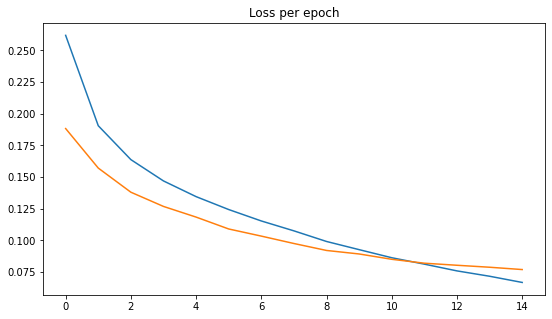

In [ ]:
plt.figure(figsize=(9,5))

plt.plot(epoch_train_loss)
plt.plot(epoch_val_loss)

plt.title('Loss per epoch')

In [ ]:
model_atten.summary()

Model: "attention__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  262400    
_________________________________________________________________
decoder_1 (Decoder)          multiple                  1430712   
Total params: 1,693,112
Trainable params: 1,693,112
Non-trainable params: 0
_________________________________________________________________


In [ ]:
def beam_search(image, beam_width = 3):
    """Beam search implementaion takes images as input"""
    image_features = Xnet_features_attention[image]

    features_val = encoder(image_features)
    start = [tokenizer.word_index["<start>"]]
    dec_word = [[start, 0.0]]
    finished_cap = []
    while len(dec_word[0][0]) < max_doc_length_x:
        temp = []
        new_cap = []
        for s in dec_word:

            predictions, hidden,attention_weights = decoder(tf.cast(tf.expand_dims([s[0][-1]], 0), tf.int32), features_val, hidden)
            predictions = tf.reshape(predictions, [predictions.shape[0],predictions.shape[2]])
            
            word_preds = np.argsort(predictions[0])[-beam_width:]
            cap,score = s
            for w in word_preds:
                candidates = [cap + [w], score - log(predictions[0][w])]
                temp.append(candidates)
        dec_word = sorted(temp, key = lambda l: l[1])[:beam_width]
        count = 0
        for cap,score in dec_word:
          if cap[len(cap)-1] == tokenizer.word_index['<end>']:
            score = score/len(cap)
            finished_cap.append([cap, score])
            count+=1
          else:
            new_cap.append([cap, score])
        beam_width -= count
        dec_word = new_cap
        # if all the dec_word reaches its end before all timesteps
        if not dec_word:
          break
        else:
          continue
    dec_word = finished_cap[-1]
    text = dec_word[0]
    score = dec_word[1]
    result = []
    text.pop(0)
    for word in text:
      if word != tokenizer.word_index['<end>']:
        result.append(tokenizer.index_word[word])
      else:
        break
    text = ' '.join(e for e in result)

    return result, text

In [ ]:
def inference(inputs):
    
    in_ = len(inputs.split()) - 1
    inputs = Xnet_features_attention[inputs]
    enc_state = tf.zeros((1, 256))
    enc_output = model_atten.layers[0](inputs)
    input_state = enc_state
    pred = []
    cur_vec = np.array([tokenizer.word_index['startseq']]).reshape(-1,1)

    for i in range(153):

        inf_output, input_state, attention_weights = model_atten.layers[1].onestep_decoder(cur_vec, input_state, enc_output)

        cur_vec = np.reshape(np.argmax(inf_output), (1, 1))
        if cur_vec[0][0] != 0:
            pred.append(cur_vec)
        else:
            break

    output = ' '.join([tokenizer.index_word[e[0][0]] for e in pred if e[0][0] != 0 and e[0][0] != 7])
    return output

In [ ]:
from tqdm.notebook import tqdm

bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_cv.values, y_cv.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = inference(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_cv.shape[0]
b = sum(bleu2)/X_cv.shape[0]
c = sum(bleu3)/X_cv.shape[0]
d = sum(bleu4)/X_cv.shape[0]

print('Bleu1 Score: ',a)
print('Bleu2 Score: ',b)
print('Bleu3 Score: ',c)
print('Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Blue score:",(a+b+c+d)/4)


Bleu1 Score:  0.18160201949602198
Bleu2 Score:  0.17133661156441182
Bleu3 Score:  0.18028301971740157
Bleu4 Score:  0.19899543673720677
-----------------------------------------------------------------------
Avg Blue score: 0.18305427187876053


In [ ]:
bleu1 = []
bleu2 = []
bleu3 = []
bleu4 = []
for img, rep in tqdm(zip(X_test.values, y_test.values)):
    
    rep = rem_fullstops(rep)
    rep = rep.split()[1:]
    rep = rep[:len(rep)-1]
    rep = ' '.join(e for e in rep)
    
    pred_rep = inference(img)
    pred_rep = rem_fullstops(pred_rep)
    
    bleu1.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (1,0,0,0)))
    bleu2.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.5,0.5,0,0)))
    bleu3.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.33,0.33,0.33,0)))
    bleu4.append(sentence_bleu([rep.split()], pred_rep.split(), weights = (0.25,0.25,0.25,0.25)))

a = sum(bleu1)/X_cv.shape[0]
b = sum(bleu2)/X_cv.shape[0]
c = sum(bleu3)/X_cv.shape[0]
d = sum(bleu4)/X_cv.shape[0]

print('Bleu1 Score: ',a)
print('Bleu2 Score: ',b)
print('Bleu3 Score: ',c)
print('Bleu4 Score: ',d)

print('-----------------------------------------------------------------------')
print("Avg Blue score:",(a+b+c+d)/4)


Bleu1 Score:  0.11383215029474758
Bleu2 Score:  0.10556084807355325
Bleu3 Score:  0.11101751407061891
Bleu4 Score:  0.1234984414656531
-----------------------------------------------------------------------
Avg Blue score: 0.1134772384761432


In [ ]:
def load_image(img_name):
    image = Image.open(img_name)
    X = np.asarray(image.convert("RGB"))
    X = np.asarray(X)
    X = preprocess_input(X)
    X = resize(X, (224,224,3))
    X = np.expand_dims(X, axis=0)
    X = np.asarray(X)
    return X

def get_result_attention_model(idx):
  plt.figure(figsize=(9,5))

  pre_Report = inference(cv_dataset['Person_id'][idx]) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_dataset['Report'][idx])

  plt.subplot(121)
  img = load_image(cv_dataset['Image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_dataset['Image2'][idx])
  plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart normal size .  the mediastinum unremarkable .  the lungs are clear .  endseq


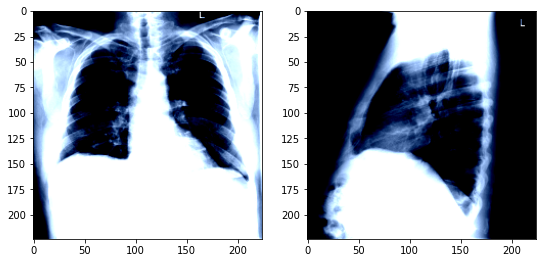

In [ ]:
get_result_attention_model(72)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity appear within normal limits . there no focal airspace opacity pleural effusion pneumothora . the are intact .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq low lung volumes with bibasilar subsegmental atelectasis .  no focal consolidations pleural effusions pneumothoraces .  cardiomediastinal silhouette within normal limits .  degenerative changes the thoracic spine .  endseq


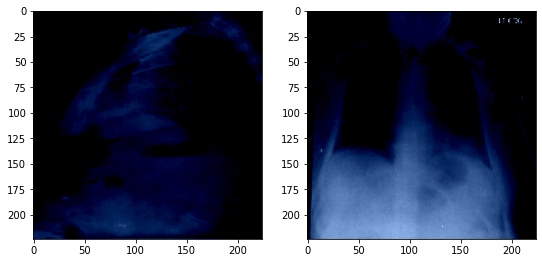

In [ ]:
get_result_attention_model(399)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart normal size . the mediastinum unremarkable . the lungs are clear .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq there are low lung volumes .  the heart size and upper mediastinum have normal appearance .  there no pulmonary vascular congestion .  there minimal right basilar atelectasis .  there no large effusion pneumothora .  the osseous structures appear intact .  endseq


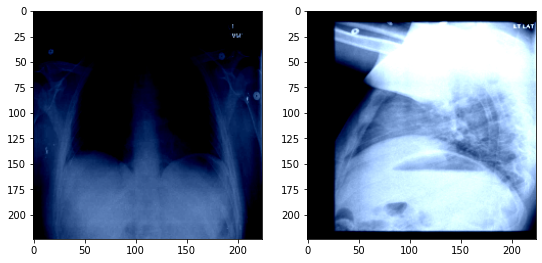

In [ ]:
get_result_attention_model(34)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity appear within normal limits . there no focal airspace opacity pleural effusion pneumothora . the are intact .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq the heart mildly enlarged .  pulmonary vascularity increased .  there again mild elevation the right hemidiaphragm .  air space disease andor atelectasis noted right lung base .  there also streaky opacity the left base .  the costophrenic are blunted .  endseq


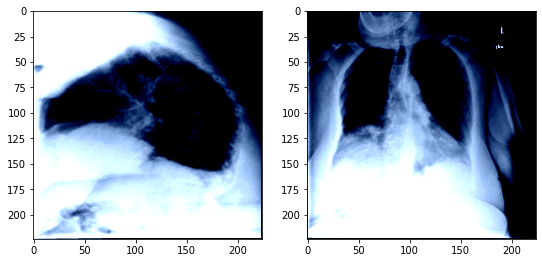

In [ ]:
get_result_attention_model(98)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity appear within normal limits . there no pleural effusion pneumothora . there are no focal air space opacity suggest pneumonia . there are no acute bony abnormalities .
------------------------------------------------------------------------------------------------------
Actual Report :  startseq stable appearance the cardiomediastinal silhouette .  the aorta calcified and tortuous .  there detroscoliosis the thoracolumbar spine .  multiple thoracic deformities appear unchanged .  there no displaced rib fracture identified .  there no pneumothora large pleural effusion .  stable changes chronic lung disease with flattening the left hemidiaphragm .  there mild right basilar airspace disease which may represent atelectasis versus infiltrate .  endseq


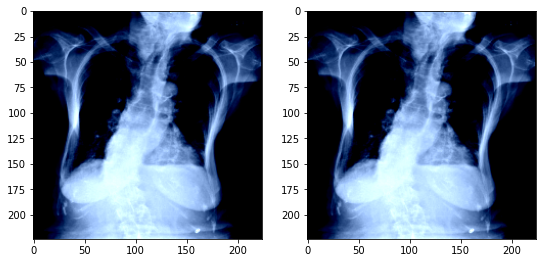

In [ ]:
get_result_attention_model(13)

In [ ]:
def get_result(beam_width,idx=0):
  
  plt.figure(figsize=(9,5))

  pre_Report,Score = beamsearch(cv_data['Person_id'][idx],beam_width) # result after 20 epochs
  print('------------------------------------------------------------------------------------------------------')
  print("Predicted Report : ",pre_Report)
  print('Score is :',Score)
  print('------------------------------------------------------------------------------------------------------')
  print("Actual Report : ",cv_data['Report'][idx])

  plt.subplot(121)
  img = load_image(cv_data['Image1'][idx])
  plt.imshow(img[0])

  plt.subplot(122)
  img = load_image(cv_data['Image2'][idx])
  plt.imshow(img[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute abnormality . there are no acute bony abnormality .
Score is : 0.40586483738241863
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  low lung volumes with no significant airspace consolidation .  no pleural effusion pneumothora .  visualized osseous structures are unremarkable appearance .  endseq


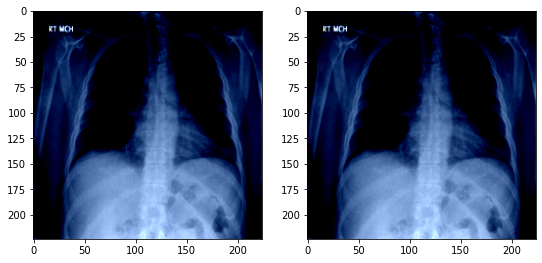

In [ ]:
#beam width = 10
get_result(10,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the cardiomediastinal silhouette within normal limits for size and contour . the lungs are normally inflated without evidence focal airspace disease pleural effusion pneumothora . visualized osseous structures are unremarkable .
Score is : 0.3412864783304306
------------------------------------------------------------------------------------------------------
Actual Report :  startseq normal heart size and mediastinal contours .  low lung volumes with no significant airspace consolidation .  no pleural effusion pneumothora .  visualized osseous structures are unremarkable appearance .  endseq


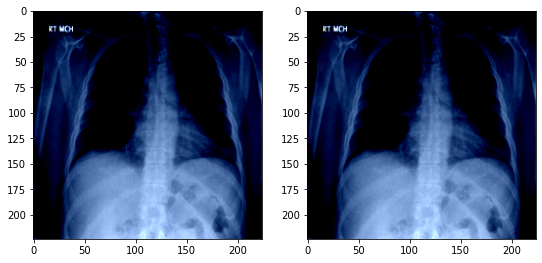

In [ ]:
#beam width = 5
get_result(5,5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the lungs are clear bilaterally . specifically no evidence focal consolidation pneumothora pleural effusion . cardio mediastinal silhouette unremarkable . visualized osseous structures the thora are without acute negative .
Score is : 0.3476788840998779
------------------------------------------------------------------------------------------------------
Actual Report :  startseq heart size and mediastinal contour within normal limits .  aortic atherosclerotic calcifications .  emphysematous changes .  nodular densities projecting over right anterior fifth and ribs .  no focal airspace consolidation pneumothora large pleural effusion .  no acute osseous abnormality .  endseq


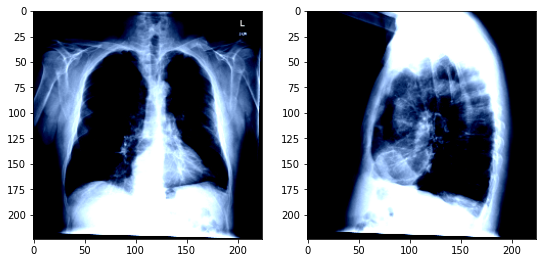

In [ ]:
#beam width = 10
get_result(10,11)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the heart size and pulmonary vascularity appear within normal limits . the lungs are free focal airspace disease . no pleural effusion pneumothora seen . there are no acute bony findings .
Score is : 0.4011605606193531
------------------------------------------------------------------------------------------------------
Actual Report :  startseq heart size within normal limits .  prominent interstitial and nodular opacities are increased since comparison eam .  there nodular opacity the right costophrenic increased since comparison eamination .  cystic lesion the right upper lobe appears similar prior eamination .  no pleural effusion pneumothora .  endseq


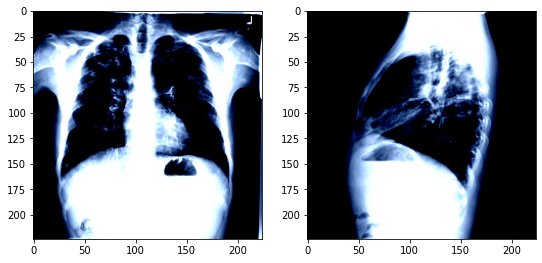

In [ ]:
#beam width = 10
get_result(10,39)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


------------------------------------------------------------------------------------------------------
Predicted Report :  the cardiomediastinal silhouette and pulmonary vasculature are within normal limits size . the lungs are clear focal airspace disease pneumothora pleural effusion . there are no acute bony abnormality .
Score is : 0.32011180980862264
------------------------------------------------------------------------------------------------------
Actual Report :  startseq no focal areas consolidation .  no suspicious pulmonary opacities .  heart size within normal limits .  no pleural effusions .  no evidence pneumothora .  osseous structures intact .  endseq


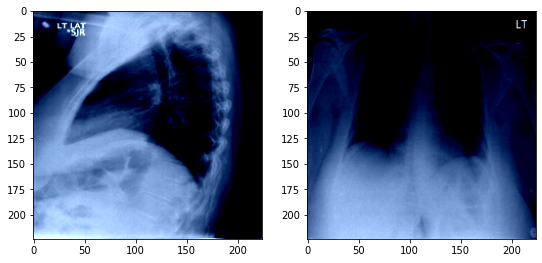

In [ ]:
#beam width = 10
get_result(10,117)

In [5]:
from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["Model", "Data","Avg_blue_score"]
x.add_row(["Encoder Decoder", "CV", 0.18114848876146578])
x.add_row(["","",""])
x.add_row(["", "Test", 0.1617484175657567])
x.add_row(["-----------------", "------------------","------------------"])


x.add_row(["Attention Mechanism", "CV",  0.199915143372483])
x.add_row(["","",""])
x.add_row(["", "Test", 0.12827193524412095])

print(x)

+---------------------+--------------------+---------------------+
|        Model        |        Data        |    Avg_blue_score   |
+---------------------+--------------------+---------------------+
|   Encoder Decoder   |         CV         | 0.18114848876146578 |
|                     |                    |                     |
|                     |        Test        |  0.1617484175657567 |
|  -----------------  | ------------------ |  ------------------ |
| Attention Mechanism |         CV         |  0.199915143372483  |
|                     |                    |                     |
|                     |        Test        | 0.12827193524412095 |
+---------------------+--------------------+---------------------+
